# Q-CTRL tutorial: Optimal control

This notebook is designed to be presented. To learn more after the presentation see: [Simulate and optimize dynamics with the superconducting systems toolkit](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-and-optimize-dynamics-with-the-superconducting-systems-toolkit#simulate-and-optimize-dynamics-with-the-superconducting-systems-toolkit).

## Example: Optimizing state transfer of a transmon.

In this example we optimize a control pulse applied to a transmon that transfers the state from the ground state to the first excited state. 

In a frame rotating with the transmon frequency and assuming that the drive is resonant, the system can be described by the following Hamiltonian:

$$
H_I(t,\mathbf{p}) = \frac{\alpha}{2} (b^\dagger)^2 b^2 + \Big(\gamma(t,\mathbf{p}) b^\dagger + H.c.\Big)  ,
$$

where
$b$ is the annihilation operator of the transmon system,
$\alpha$ is the transmon anharmonicity,
and $\gamma(t,\mathbf{p})$ is a complex time-dependent drive applied to the that is parametrized by a vector of control variables $\bf{p}$.

Let's use optimal control to find a drive $\gamma(t)$ which transfers the state of the transmon from $|\psi \rangle_{\mathrm{initial}}=|0 \rangle$ to a final target state $|\psi_{\mathrm{target}} \rangle = |1 \rangle$

This is achieved by performing an optimization problem that minimizes the cost

$$
C(\mathbf{p}) = 1 - || \langle \psi_{\mathrm{target}} | \psi_{\mathrm{final}}(\mathbf{p}) \rangle ||^2
$$

where $| \psi_{\mathrm{final}}(\mathbf{p}) \rangle = |\psi(T,\mathbf{p}) \rangle $ is the solution of the differential equation

$$
\frac{d|\psi(t)\rangle}{dt} = -i H_I(t,\mathbf{p}) |\psi(t)\rangle
$$

with the initial condition of $|\psi(0)\rangle = |\psi_{\mathrm{initial}}\rangle$.

After the optimization is completed, the minimum cost is returned along with the best controls.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Q-CTRL imports
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_populations, plot_controls

# Starting a session with the API
qctrl = Qctrl()

# Plotting style
plt.style.use(get_qctrl_style())

In [2]:
# Gate duration and number of optimizable piecewise-constant segments.
gate_duration = 3e-6  # s
segment_count = 20

# Physical properties of the transmon.
transmon_dimension = 5
alpha = 2 * np.pi * 0.3e6  # rad.Hz
gamma_max = 2 * np.pi * 0.3e6  # rad.Hz

# Create transmon object with optimizable drive.
transmon = qctrl.superconducting.Transmon(
    dimension=transmon_dimension,
    anharmonicity=alpha,
    drive=qctrl.superconducting.ComplexOptimizableSignal(segment_count, 0, gamma_max),
)

# Define initial state as |0>.
initial_state = np.zeros(transmon_dimension)
initial_state[0] = 1


#Define target state as |1>.
target_state = np.zeros(transmon_dimension)
target_state[1] = 1

optimization_result = qctrl.superconducting.optimize(
    transmons=[transmon],
    cavities=[],
    interactions=[],
    gate_duration=gate_duration,
    initial_state=initial_state,
    target_state=target_state,
    sample_count=512,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1253389") has started.
Your task calculate_optimization (action_id="1253389") has completed.


In [3]:
print(f"Optimized infidelity: {optimization_result['infidelity']:.3e}")

Optimized infidelity: 3.390e-10


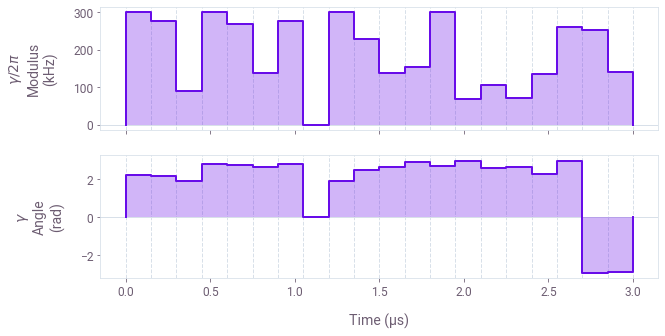

In [4]:
optimized_drive = optimization_result["optimized_values"]["transmon.drive"]
plot_controls(
    plt.figure(),
    {
        r"$\gamma$": qctrl.utils.pwc_arrays_to_pairs(gate_duration, optimized_drive),
    },
)

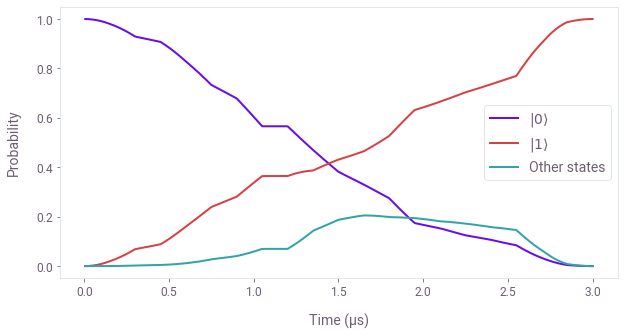

In [5]:
states = optimization_result["state_evolution"]

population_0 = np.abs(states[:, 0]) ** 2
population_1 = np.abs(states[:, 1]) ** 2
population_others = 1 - population_0 - population_1

plot_populations(
    plt.figure(),
    optimization_result["sample_times"],
    {
        r"$|0\rangle$": population_0,
        r"$|1\rangle$": population_1,
        "Other states": 1 - population_0 - population_1,
    },
)

## Problem: Optimizing state transfer of a bandwidth-limited transmon. 

The following code adds a bandwidth filter between the control pulses and the superconducting qubit. The bandwidth filter appears to have increased the cost (and hence reduced fidelity) of the best pulse found by the optimization.

(a) Why has the cost increased?

(b) Can you change the parameters of the control pulse to get an optimized pulse with a cost function less than 0.001?

In [6]:
# Gate duration and number of optimizable piecewise-constant segments.
# Gate duration and number of optimizable piecewise-constant segments.
gate_duration = 3e-6  # s
segment_count = 20

# Physical properties of the transmon.
transmon_dimension = 5
alpha = 2 * np.pi * 0.3e6  # rad.Hz
gamma_max = 2 * np.pi * 0.3e6  # rad.Hz
cutoff_frequency = 0.3e6 # rad.Hz

# Create transmon object with optimizable drive.
transmon = qctrl.superconducting.Transmon(
    dimension=transmon_dimension,
    anharmonicity=alpha,
    drive=qctrl.superconducting.ComplexOptimizableSignal(segment_count, 0, gamma_max),
)

# Define initial state as |0>.
initial_state = np.zeros(transmon_dimension)
initial_state[0] = 1


#Define target state as |1>.
target_state = np.zeros(transmon_dimension)
target_state[1] = 1

optimization_result = qctrl.superconducting.optimize(
    transmons=[transmon],
    cavities=[],
    interactions=[],
    gate_duration=gate_duration,
    initial_state=initial_state,
    target_state=target_state,
    sample_count=512,
    cutoff_frequency=cutoff_frequency,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1253390") has started.
Your task calculate_optimization (action_id="1253390") has completed.


In [7]:
print(f"Optimized infidelity: {optimization_result['infidelity']:.3e}")

Optimized infidelity: 5.660e-01


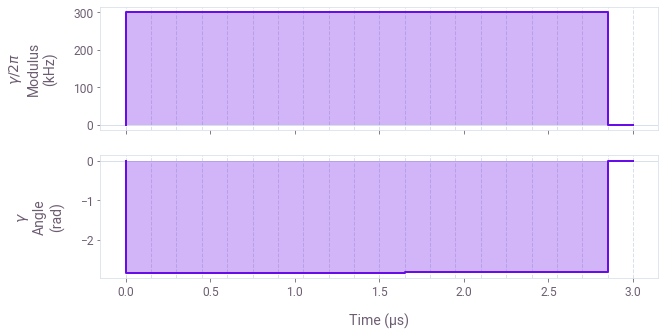

In [8]:
optimized_drive = optimization_result["optimized_values"]["transmon.drive"]
plot_controls(
    plt.figure(),
    {
        r"$\gamma$": qctrl.utils.pwc_arrays_to_pairs(gate_duration, optimized_drive),
    },
)

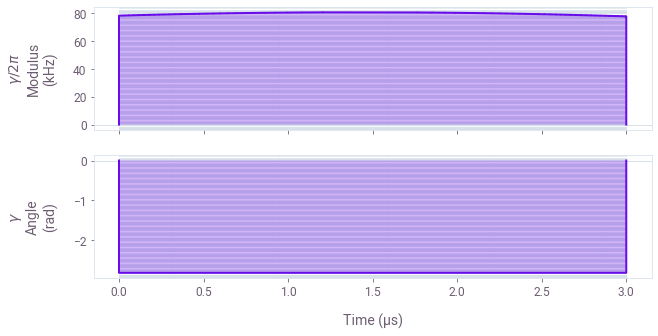

In [9]:
filtered_optimized_drive = optimization_result["optimized_values"]["transmon.drive_filtered"]
plot_controls(
    plt.figure(),
    {
        r"$\gamma$": qctrl.utils.pwc_arrays_to_pairs(gate_duration, filtered_optimized_drive),
    },
)

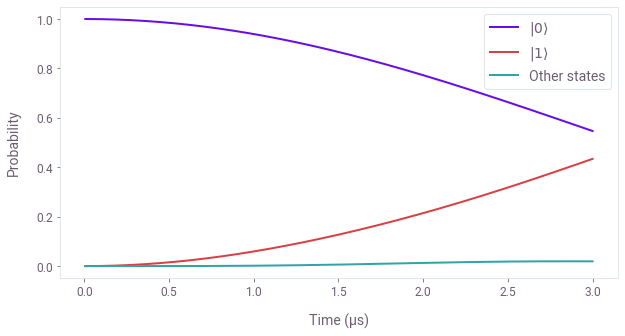

In [10]:
states = optimization_result["state_evolution"]

population_0 = np.abs(states[:, 0]) ** 2
population_1 = np.abs(states[:, 1]) ** 2
population_others = 1 - population_0 - population_1

plot_populations(
    plt.figure(),
    optimization_result["sample_times"],
    {
        r"$|0\rangle$": population_0,
        r"$|1\rangle$": population_1,
        "Other states": 1 - population_0 - population_1,
    },
)

## Homework: Optimizing a CNOT gate with two coupled transmons.

Can you create an optimization that optimized the drives on two transmon gates that are directly interacting with one another and achieves a controlled NOT gate?